In [445]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras

# jupyter command - allows plots to show up
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from datetime import datetime

# fixes the random number seed to ensure reproducible results
np.random.seed(69)

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

In [446]:
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5000)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)


# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

In [447]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset)-look_forward,:]

In [448]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

In [449]:
# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [450]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(look_forward*3))
model.add(Dense(look_forward*2))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=3, verbose=2)

Epoch 1/5
3s - loss: 0.0087
Epoch 2/5
2s - loss: 0.0043
Epoch 3/5
2s - loss: 0.0038
Epoch 4/5
2s - loss: 0.0032
Epoch 5/5
2s - loss: 0.0029


In [451]:
batch = 2
for i in range (10):
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)

Epoch 1/1
3s - loss: 0.0032
Epoch 1/1
3s - loss: 0.0029
Epoch 1/1
3s - loss: 0.0029
Epoch 1/1
3s - loss: 0.0026
Epoch 1/1
3s - loss: 0.0024
Epoch 1/1
3s - loss: 0.0023
Epoch 1/1
3s - loss: 0.0023
Epoch 1/1
3s - loss: 0.0023
Epoch 1/1
3s - loss: 0.0022
Epoch 1/1
3s - loss: 0.0020


In [452]:
batch = 1
for i in range (10):
    model.fit(trainX, trainY, epochs=1, batch_size=batch, verbose=2)

Epoch 1/1
7s - loss: 0.0026
Epoch 1/1
6s - loss: 0.0025
Epoch 1/1
6s - loss: 0.0024
Epoch 1/1
6s - loss: 0.0024
Epoch 1/1
6s - loss: 0.0023
Epoch 1/1
6s - loss: 0.0023
Epoch 1/1
6s - loss: 0.0022
Epoch 1/1
7s - loss: 0.0022
Epoch 1/1
6s - loss: 0.0021
Epoch 1/1
6s - loss: 0.0020


In [453]:
def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    
    # reshape the dataset
    data = dataset.T
    data = data.reshape(1, 1, data.shape[0])
    
    # make a prediction
    prediction = model.predict(data)
    
    # un-normalize the data set
    prediction = scaler.inverse_transform(prediction)
    
    return prediction

In [454]:
def predictAt(point):
    pred = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back))
    actu = dataset_orig[point:point+look_forward]
    plt.plot(pred.reshape(look_forward))
    plt.plot(actu)

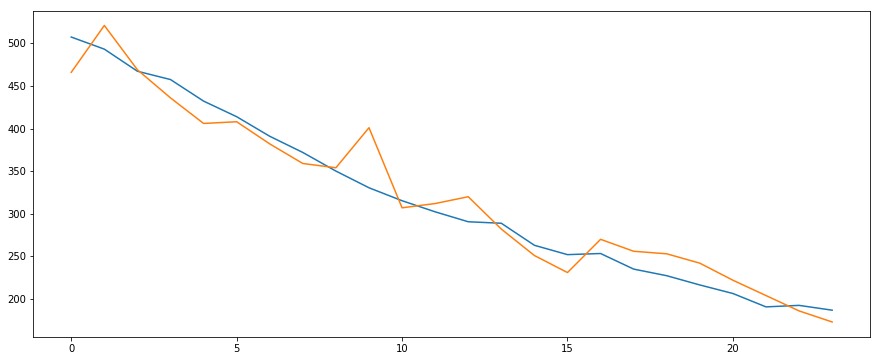

In [461]:
predictAt(288)

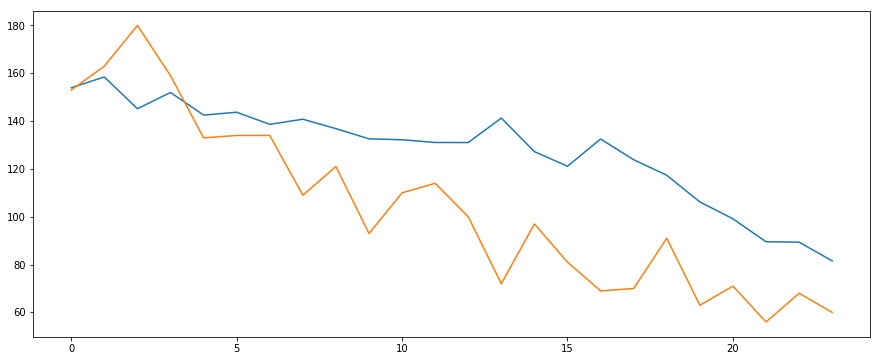

In [456]:
predictAt(288 + 24)

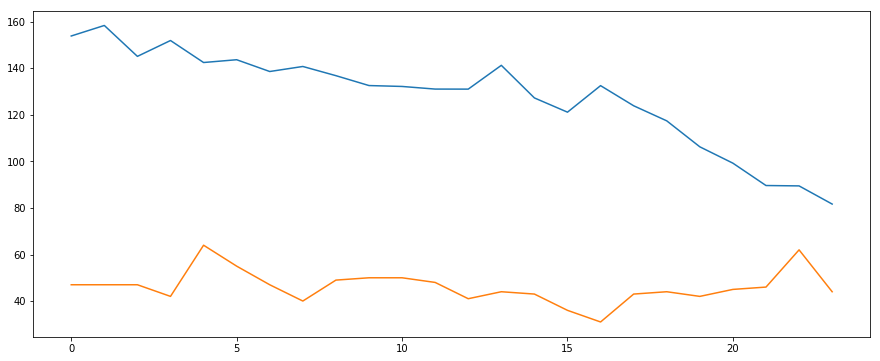

In [457]:
predictAt(288+48)

395.45 RMSE


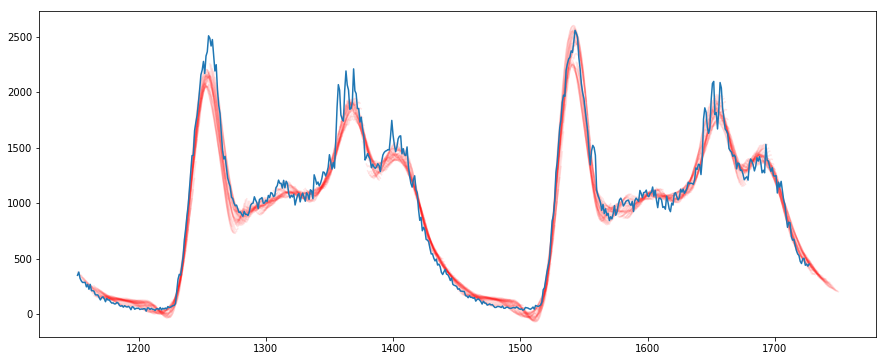

In [480]:
predictions = np.array([])
true_vals = np.array([])

day = 4

delta = 1

for i in range (288*2/delta):
    # the point where the model will predict
    point = 288*day + i * delta
    
    prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(24)
    
    # plots the predictions
    plt.plot(range(point, point+24),prediction, color="red", alpha=0.1)
    
    predictions = np.append(predictions, prediction)
    true_vals = np.append(true_vals,dataset_orig[i:i+24]) 

predictions = predictions.reshape(len(predictions)/24, 24)
true_vals = true_vals.reshape(len(true_vals)/24, 24)


print "%.2f RMSE" % (math.sqrt(mean_squared_error(true_vals, predictions)))

plt.plot(range(288*day,288*day+288*2),dataset_orig[288*day:288*day+288*2,0])


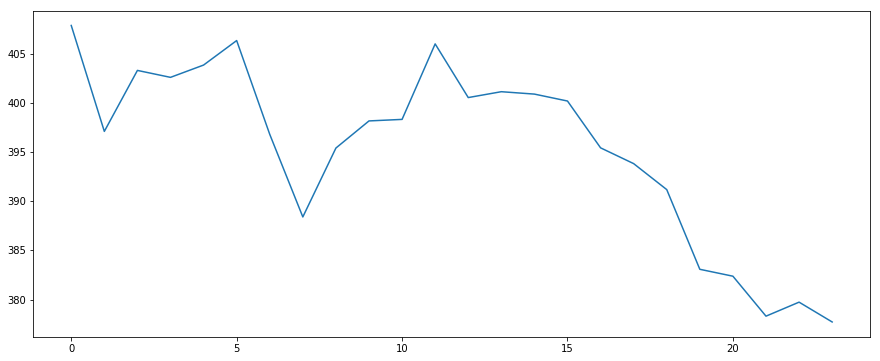

In [476]:
err = np.array(range(24)).astype('float32')
for i in range(look_forward):
    err[i] = math.sqrt(mean_squared_error(true_vals[:,i],predictions[:,i]))
plt.plot(err)